# Libraries

In [1]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from imutils import build_montages

# Function dan Load data

In [2]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)

		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding

		return image

In [3]:
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")

	return features

In [4]:
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))

  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)

  return hist

In [5]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

In [6]:
dataset_dir = '/content/drive/My Drive/BCML/CV/numbers'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

# Size 28, Method Hog

In [7]:
resize_image_size = 28
extraction_method = 'hog'

In [8]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

print("Data loaded!")

Data loaded!


In [9]:
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

**Logistic Regression**

In [10]:
logreg = LogisticRegression(max_iter=125)
logreg.fit(feature_train, label_train)
predictions = logreg.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of logistic regression classifier on test set: 0.97
F1 0.9666237179954377
Precision 0.9668019197337042
Recall 0.9666666666666668


**LinearSVC**

In [11]:
classifier_lsvc = LinearSVC()
classifier_lsvc.fit(feature_train, label_train)
predictions = classifier_lsvc.predict(feature_test)

classification_report(label_test, predictions)
print('Accuracy of LinearSVC on test set: {:.2f}'.format(classifier_lsvc.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

Accuracy of LinearSVC on test set: 0.97
F1 0.9744480121388173
Precision 0.974462455498822
Recall 0.9744444444444444


**Random Forest**

In [12]:
model = RandomForestClassifier(n_estimators=100, random_state=10)
model.fit(feature_train, label_train)

predictions = model.predict(feature_test)

classification_report(label_test, predictions)

print(pd.crosstab(label_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))


Predicted    0    1    2  All
True                         
0          294    3    3  300
1            3  294    3  300
2            5    0  295  300
All        302  297  301  900


In [13]:
print(classification_report(label_test, predictions))

print('Accuracy of Random Forest on test set: {:.2f}'.format(model.score(feature_test, label_test)))
print("F1", f1_score(label_test, predictions, average="macro"))
print("Precision", precision_score(label_test, predictions, average="macro"))
print("Recall", recall_score(label_test, predictions, average="macro"))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.99      0.98      0.98       300
           2       0.98      0.98      0.98       300

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900

Accuracy of Random Forest on test set: 0.98
F1 0.9811219935143737
Precision 0.9811584562855162
Recall 0.9811111111111112


In [14]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = classifier_lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

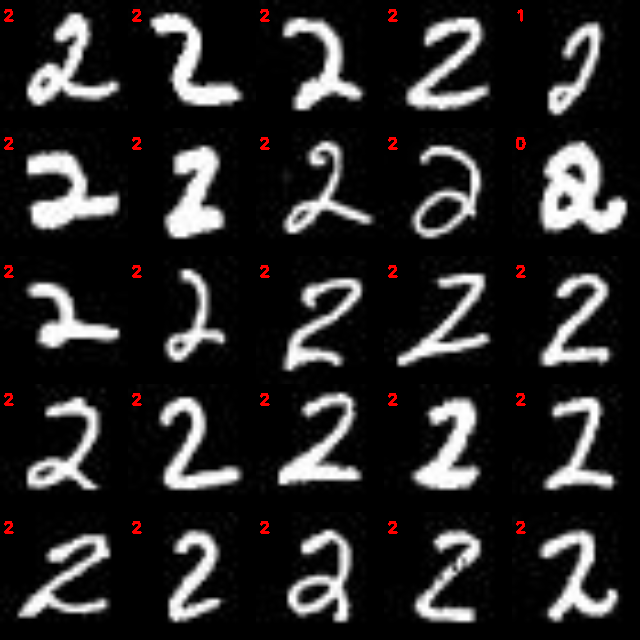

In [15]:
montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

Kesimpulan

Hasil paling baik didapatkan dengan Random Forest(estimator 100, random state 10) dengan size image 28 dan menggunakan hog.